# Урок 4. Деревья решений

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 10, n_informative = 10, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=10)

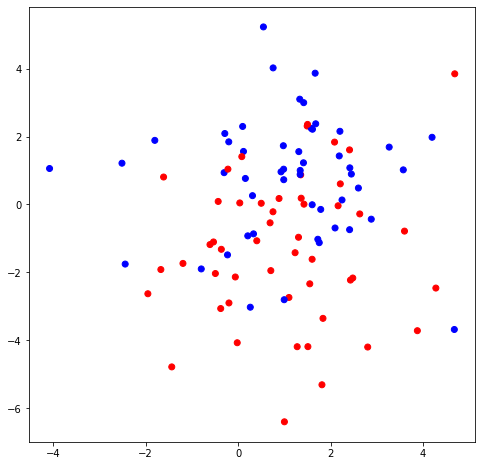

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}# сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции
class Tree:
    
    def __init__(self,curr_leafs_count,max_depth, max_leafs_count):
        self.curr_leafs_count = curr_leafs_count
        self.max_depth=max_depth
        self.max_leafs_count=max_leafs_count
        self.curr_depth=0
        
    def get_curr_leafs_count(self):
        return self.curr_leafs_count
    
    def get_curr_depth(self):
        return self.curr_depth
        
    def build_tree(self, data, labels, curr_depth=1 ):
       
        quality, t, index = find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        # или глубина дерева больше максимальной или количество листьев больше нмаксимального
        self.curr_depth=curr_depth
        if quality == 0 or curr_depth >= self.max_depth or self.curr_leafs_count >= self.max_leafs_count-1:
            self.curr_leafs_count += 1
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, curr_depth+1)
        false_branch = self.build_tree(false_data, false_labels, curr_depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

# Решение задания 1

In [14]:
# Построим дерево по обучающей выборке
#текущее кол-во листьев
curr_leafs_count=0
#количество листьев макс
max_leafs_count=10
#глубина дерева макс
max_depth=5

treeObj=Tree(curr_leafs_count,max_depth, max_leafs_count)
my_tree = treeObj.build_tree(train_data, train_labels)
print(treeObj.get_curr_leafs_count())
print(treeObj.get_curr_depth())

6
3


In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 3
Порог 0.46285914763550995
--> True:
  Индекс 6
  Порог 1.3052928847399947
  --> True:
    Индекс 8
    Порог 1.1587139871707843
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 1
--> False:
  Индекс 0
  Порог 0.8849544724195552
  --> True:
    Индекс 6
    Порог 0.5777848617028095
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

94.28571428571428

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

80.0

2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [21]:
# И класс терминального узла (листа)

class LeafEx:
    
    def __init__(self, index,t,data, labels):
        self.index=index
        self.t=t
        self.data = data
        self.labels = labels
        self.true_branch=None
        self.false_branch=None
        self.prediction = self.predict()
        
    def predict(self):
         
        prediction = np.mean(np.array(self.labels))
        return prediction        

In [22]:
def gini_var(labels):
    impurity=labels.var()
    return impurity
    

In [23]:
def classify_objectEx(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, LeafEx):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [24]:
# Расчет качества

def qualityEx(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini_var(left_labels) - (1 - p) * gini_var(right_labels)

In [25]:
# Нахождение наилучшего разбиения

def find_best_splitEx(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini_var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = qualityEx(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [26]:
# Построение дерева с помощью рекурсивной функции
class TreeEx:
    
    def __init__(self,curr_leafs_count,max_depth, max_leafs_count):
        self.curr_leafs_count = curr_leafs_count
        self.max_depth=max_depth
        self.max_leafs_count=max_leafs_count
        self.curr_depth=0
        
    def get_curr_leafs_count(self):
        return self.curr_leafs_count
    
    def get_curr_depth(self):
        return self.curr_depth
        
    def build_tree(self, data, labels, curr_depth=1 ):
       
        quality, t, index = find_best_splitEx(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        # или глубина дерева больше максимальной или количество листьев больше нмаксимального
        self.curr_depth=curr_depth
        if quality == 0 or curr_depth >= self.max_depth or self.curr_leafs_count >= self.max_leafs_count-1:
            self.curr_leafs_count += 1
            return LeafEx(index,t,data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, curr_depth+1)
        false_branch = self.build_tree(false_data, false_labels, curr_depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

In [27]:
def predictEx(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_objectEx(obj, tree)
        classes.append(prediction)
    return classes

In [28]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_samples=100,n_features = 10, n_informative = 10, 
                                                      random_state=10)

In [29]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [30]:
# Построим дерево по обучающей выборке
#текущее кол-во листьев
curr_leafs_count=0
#количество листьев макс
max_leafs_count=10
#глубина дерева макс
max_depth=3

treeObj=TreeEx(curr_leafs_count,max_depth, max_leafs_count)
my_tree = treeObj.build_tree(train_data, train_labels)
print(treeObj.get_curr_leafs_count())
print(treeObj.get_curr_depth())

4
3
